<a id='top'></a>

# Detective Conan Episodes – Web Scraping and SQL
---

### Table of Contents

1.  [Introduction](#intro)
2.  [Web Scraping](#scrape)
3.  [Analysis Using SQLite](#sqlite)
4.  [Conclusion](#end)

<a id='intro'></a>

## Introduction

[Back to Top](#top)

![conan_header](images/conan_header.png)

*Detective Conan* (also known as *Case Closed* in America) is a Japanese detective anime series.  It's a show introduced to me by my girlfriend, who used to watch it on Cartoon Network's Adult Swim block when she was a kid.  If you aren't familiar with this series, one thing to know is that it's been running non-stop since 1996–this show is almost as old as me!  This also means it has a substantial amount of data we can analyze.  The [Detective Conan World Wiki] (DCW Wiki) contains a list of every single episode, along with data such as when the episode aired and what kind of plot points were contained in the episode.  My goal for this will be to scrape the data from the wiki, and do some analysis using SQL.

[Detective Conan World Wiki]:  http://www.detectiveconanworld.com/wiki/Anime

<a id='scrape'></a>

## Web Scraping

[Back to Top](#top)

The first thing I had to do was to scrape the episode data from the webpage, starting from episode one to the most recent episode as of today (January 23, 2018).  I used the Beautiful Soup package to extract the data.  I've only ever done web scraping once or twice before, so I was a little nervous that I couldn't do it.  But at the end, seeing the dataset I scraped and knowing that I got all the data I wanted was definitely a confidence booster.  That said, if there was a way that I could have made this easier or more efficient please let me know.

In [3]:
from urllib import urlopen as ureq
from bs4 import BeautifulSoup

my_url = 'http://www.detectiveconanworld.com/wiki/Anime'

#openning connection grabbing page
uclient = ureq(my_url)
html_page = uclient.read()
uclient.close()

#html parsing
soup = BeautifulSoup(html_page, 'html.parser')

In [4]:
import csv
from pprint import pprint

#grabs each season table
season_table = soup.find_all('table', {'class':'wikitable seasontable headerlink'})

data = []

#scrape data
for episode in season_table:
    trs = episode.find_all('tr')
    for tr in trs:
        ep_dict = {}
        tds = tr.find_all('td')
        for td in tds[0:1]:
            ep_dict['japanese_episode_number'] = td.text.strip().encode('ascii','ignore')
        for td in tds[1:2]:
            ep_dict['english_episode_number'] = td.text.strip().encode('ascii','ignore')
        for td in tds[2:3]:
            ep_dict['episode_title'] = td.a.text.strip().encode('ascii','ignore')
        for td in tds[3:4]:
            ep_dict['original_airdate'] = td.text.strip().encode('ascii','ignore')
        for td in tds[4:5]:
            ep_dict['english_airdate'] = td.text.strip().encode('ascii','ignore')
        for td in tds[5:6]:
            plot_list = []
            all_story_types = ['New character', 'Character development', 'Magic Kaito', 'Romance', 'Characters pasts',\
                                   'Black Organization', 'FBI']
            plot_points = td.find_all('a', {'href':'/wiki/Detective_Conan_Wiki:Plot_Legend'})
            for point in plot_points:
                story = point['title'].strip().encode('ascii','ignore')
                plot_list.append(story)
            for story_type in all_story_types:
                if story_type in plot_list:
                    ep_dict[story_type] = 'yes'
                else:
                    ep_dict[story_type] = 'no'
        for td in tds[6:7]:
            try:
                manga_source = td.a.text
            except AttributeError:
                manga_source = td.b.text
            ep_dict['manga_source'] = manga_source.strip().encode('ascii','ignore')
        for td in tds[7:8]:
            ep_dict['next_conans_hint'] = td.text.strip().encode('ascii','ignore')
        data.append(ep_dict)

#Find indexes of empty dictionaries in list
empty = [i for i,x in enumerate(data) if x == {}]
counter = 0

#delete the empty dictionaries using the indexes
for i in empty:
    del data[i - counter]
    counter += 1
    
#pprint(data)

After getting the data, the next thing I did was to put the data into a list of dictionaries, with each dictionary in the list containing data for each individual episode.  I then exported the list to a csv file so I could use it to make a database.

In [5]:
#write scraped data to a csv file
keys = data[0].keys()

with open('conan_tv.csv', 'wb') as output_file:
    output_file.write('romance,new_character,character_development,magic_kaito,english_airdate,next_conans_hint,original_airdate,episode_title,japanese_episode_number,characters_pasts,black_organization,manga_source,fbi,english_episode_number\n')
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writerows(data)

output_file.close()

#print 'All Done!'

<a id='sqlite'></a>

## Analysis Using SQLite

[Back to Top](#top)

Now that I had the csv, just to make things easier on myself and save time, I used DB Browser for SQLite to create the database and table for the data; I decided to call the table **tv**.

![table](images/table.PNG)

An issue I ran into when creating the table was that I was orignally going to put episode numbers as INTEGER types.  However, the TV specials in the data don't have numbers for their episode; for instance the *Magic Kaito* specials have "MKS#" listed for their episode numbers.  Thus, I had to keep the episode numbers as text.

After I was done creating the database, I decided that I wanted to perform all of my queries within this notebook.  To that end, I chose to use the sqlite3 package to be able to use SQL in Python.

### Total Episodes in Database

<a id='total_eps'></a>

In [9]:
import sqlite3

#connect to the database
conn = sqlite3.connect('conan.db')
c = conn.cursor()

#write an sql query
QUERY = 'SELECT COUNT(id) \
         FROM tv;'

def sql_query(query, message):
    '''Takes a sql query and a message and displays the message along side the result of the query.'''
    info = c.execute(query).fetchall()
    return message.format(info[0][0])

print sql_query(QUERY, 'total episodes in database: {}')
print 993 * 24
print 993 * 24 / 60.
print 993 * 24 / 60 / 24.

total episodes in database: 993
23832
397.2
16.5416666667


There a total of 993 episodes in this database; that includes all of the regular episodes, TV specials, reruns, and remastered episodes.  If we assume each episode has a runtime of 24 minutes, excluding commercials, 993 episodes is equivalent to:

- 23832 minutes,
- roughly 397 hours, or
- about 16.5 days.

That said, *Detective Conan* sometimes has specials that are an hour to two and a half hours long, so the actual runtime of all 993 episodes should be slightly higher.  Regardless, the point is:  this is not a series to binge watch in one sitting.

### Number of Regular Episodes

In [10]:
QUERY = 'SELECT japanese_episode_number \
         FROM tv \
         WHERE id = 993'

print sql_query(QUERY, 'total number of regular episodes: {}')
print 993 - 890

total number of regular episodes: 890
103


There are 890 of what I am going to call regular episodes, or all the episodes that are not reruns, remasters, or TV specials.  If we subtract the total number of regular episodes from the amount of episodes total, we get 103, which is the number of episodes that are TV specials, reruns, and remasters.

### Plot Elements

The DCW Wiki anime chart contains a collumn called "Plot" which indicates whether anything significant happened during an episode that is relevant to the overall plot of the series.  The "Plot" collumn utilizes different symbols to specify what sort of plot development occured.  Below is the wiki's description of what each symbol means:

![legend](images/plot_legend.PNG)

Using this plot data, I wanted to see how many episodes contained any sort of plot development; i.e. episodes containing at least one of the above symbols.

In [12]:
QUERY = "SELECT COUNT(id) \
         FROM tv \
         WHERE (romance == 'yes' OR \
         new_character == 'yes' OR \
         character_development == 'yes' OR \
         characters_pasts == 'yes' OR \
         black_organization == 'yes' OR \
         magic_kaito == 'yes' OR fbi == 'yes');"

print sql_query(QUERY, 'episodes with plot: {}')
print 443 / 993.

episodes with plot: 443
0.44612286002


443 episodes or about 45% of all episodes contain some sort of plot element.  In regards to this, *Detective Conan* is less of a plot-driven show and more of a "case of the week" show, with emphasis placed on presenting a new and intriguing mystery and seeing how Conan can use his skills in deduction to solve it.  Thus, plot developments in *Detective Conan* are typically very small and the story moves at the pace of a sloth in the body of a snail.  But I assume this is a nonissue for most fans who just enjoy being along for the ride.

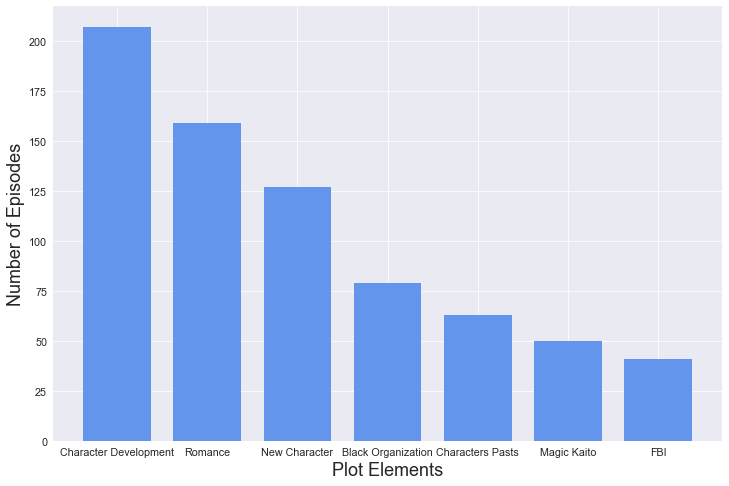

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#put the csv data into a pandas df
conan = pd.read_csv('conan_tv.csv')
#for each story type put the number of yes into a list "y" to use to make the bar chart
story_types = ['new_character', 'character_development', 'magic_kaito', 'romance', 'characters_pasts',\
                                   'black_organization', 'fbi']
y = []
for story_type in story_types:
    y.append(conan.groupby([story_type]).size()[1])
y.sort(reverse=True)

#plot the number of plot elements
sns.set_context('paper', font_scale=1.35)
x = np.arange(len(story_types))
bar_width = 0.75
plt.figure(figsize=(12,8))
plt.bar(x, y, bar_width, color = 'cornflowerblue')
plt.xlabel('Plot Elements', fontsize=18)
plt.ylabel('Number of Episodes', fontsize=18)
plt.xticks(np.arange(len(story_types)), ['Character Development', 'Romance', 'New Character', 'Black Organization', \
                                         'Characters Pasts', 'Magic Kaito', 'FBI'])
plt.show()


I wanted to compare the amount of each plot elements throughout the series, so to make the comparision easier I created a bar chart instead of doing normal SQL queries.  Character development has the most amount of episodes, followed by romance.  I was a little surprised that the FBI are featured in about the same amount of episodes as Kaitou Kid considering, that the FBI were introduced into the series way later than Kaito Kid.

### Source Material

In [29]:
QUERY = "SELECT COUNT(id) \
         FROM tv \
         WHERE manga_source == 'TV Original';"

print sql_query(QUERY, 'tv originals: {}')
print 993 - 368

tv originals: 368
625


625 of all the episodes are based on the *Detective Conan* or *Magic Kaito* mangas, while 368 are not based on any source material.

### Next Conan's Hint

In [36]:
QUERY = "SELECT next_conans_hint, COUNT(next_conans_hint) AS number \
         FROM tv \
         WHERE NOT next_conans_hint == 'N/A' \
         GROUP BY next_conans_hint \
         ORDER BY number desc \
         LIMIT 10;" 

#put sql query into a pandas df
top_hints = pd.read_sql_query(QUERY, conn)
#name the collumns
top_hints.columns = ['Hint', 'Frequency']
#create the index for the df
top_hints.index = np.arange(1, len(top_hints) + 1)

#close connection
c.close()
conn.close()

print ''
print 'Top 10 "Next Conan\'s Hint"'
print top_hints


Top 10 "Next Conan's Hint"
             Hint  Frequency
1           Clock          5
2             Ice          5
3   Cassette tape          4
4             Cat          4
5      Cell phone          4
6          Mirror          4
7       Nameplate          4
8           Paint          4
9        Umbrella          4
10           Wind          4


The "Next Conan's Hint" is a hint given at the end of every episode; it gives viewers a heads-up about something they should look out for in the next episode that will be important for Conan's deduction.  Given the length of the series, I was certain that some of the hints had to have been repeated at least a few times.  I was interested to see that cat, was the only living thing appearing in this list and was featured four times.  I also thought that cassette tape and cell phone being featured the same amount of times is an indicator of the show's age.

<a id=end></a>

## Conclusion

[Back to Top](#top)

Here is where I'll conclude the analysis.  One idea I came up with when doing this project was to somehow use machine learning to try and predict the culprit in an episode of *Detective Conan*.  I'll have to work out the details and see if it is even possible to do such a thing, so I'll save that project for another day.

## References

http://www.detectiveconanworld.com/wiki/Anime

https://res.cloudinary.com/sfp/image/upload/c_fill,q_60/oth/FunimationStoreFront/1353682/English/1353682_English_ShowDetailHeaderDesktop_463281e7-5250-e711-8175-020165574d09.jpg